In [25]:
from itertools import count

import pandas as pd
from codes.load_and_save_covid_data import load_and_save_covid_data
import matplotlib.pyplot as plt

In [59]:
# Load COVID dataset
covid_df = load_and_save_covid_data()  # Assuming this function loads your dataset
covid_df['date'] = pd.to_datetime(covid_df['date'])

# Load population data
pop_df = pd.read_excel(
    "data/CD2022_Collected_Imputed_Population_and_Total_Municipality_and_State_20231222.xlsx",
    skiprows=2
)

[✓] Found saved COVID dataset at data/covid_brazil_combined.csv. Loading it...


In [60]:
# Drop rows with missing municipality info
pop_df = pop_df.dropna(subset=['COD. UF', 'COD. MUNIC'])

# Rename and prepare codes
pop_df = pop_df.rename(columns={
    'COD. UF': 'state_code',
    'COD. MUNIC': 'municipality_code_suffix',
    'NOME DO MUNICÍPIO': 'municipality_name',
})

pop_df['state_code'] = pop_df['state_code'].astype(int)
pop_df['municipality_code_suffix'] = pop_df['municipality_code_suffix'].astype(int)

pop_df['Codmundv'] = (
    pop_df['state_code'].astype(str).str.zfill(2) +
    pop_df['municipality_code_suffix'].astype(str).str.zfill(5)
).astype(int)

In [64]:
# ========== 1. Flag cities with 60-day zero-case streak ==========
flagged_zero_cities = []
count_zero_cities = 0

for ibge_id, group in covid_df.groupby('ibgeID'):
    group_sorted = group.sort_values('date')
    zero_cases = group_sorted['newCases'].fillna(0) == 0
    rolling_zero = zero_cases.rolling(window=40).sum()
    if (rolling_zero == 40).any():
        flagged_zero_cities.append(ibge_id)
        count_zero_cities += 1
print(f"Count of Zero Cities: {count_zero_cities}")

Count of Zero Cities: 4029


In [65]:
# ========== 2. Flag cities with negative values ==========
flagged_negative_cities = []
count_negative = 0

for ibge_id, group in covid_df.groupby('ibgeID'):
    if (group['newCases'].fillna(0) < -200).any():
        count_negative += 1
        flagged_negative_cities.append(ibge_id)
print(f"Count of Negative Cities: {count_negative}")

Count of Negative Cities: 667


In [66]:
# ========== 3. Combine both flagged groups ==========
combined_flagged_cities = set(flagged_zero_cities) | set(flagged_negative_cities)

combined_flagged_df = pd.DataFrame(combined_flagged_cities, columns=['Codmundv'])
combined_flagged_df = combined_flagged_df.merge(
    pop_df[['Codmundv', 'municipality_name']],
    on='Codmundv',
    how='left'
)

print(f"\n✅ Total cities flagged (zero-case or negative cases): {len(combined_flagged_df)}")
print(combined_flagged_df.sample(5, random_state=1))
3300936 in combined_flagged_cities


✅ Total cities flagged (zero-case or negative cases): 4262
      Codmundv         municipality_name
678    3163409       São José do Goiabal
1684   4214003        Presidente Getúlio
745    2704807                 Maribondo
1296   1100320     São Miguel do Guaporé
331    2105963  Lagoa Grande do Maranhão


True

In [67]:
# ========== 4. See non-flagged cities ==========
all_cities = covid_df['ibgeID'].unique()
non_flagged_cities = [city for city in all_cities if city not in combined_flagged_cities]

non_flagged_df = pd.DataFrame(non_flagged_cities, columns=['Codmundv'])
non_flagged_df = non_flagged_df.merge(
    pop_df[['Codmundv', 'municipality_name']],
    on='Codmundv',
    how='left'
)

print(f"\n✅ Number of non-flagged cities: {len(non_flagged_df)}")
print(non_flagged_df.sample(15, random_state=42))


✅ Number of non-flagged cities: 1335
      Codmundv        municipality_name
898    4207502                  Indaial
1062   4312302                 Miraguaí
1253   5205802         Corumbá de Goiás
298    3136207           João Monlevade
237    2926004                  Remanso
481    3509502                 Campinas
240    2927002                 Rio Real
277    3113404                Caratinga
415    3304110               Porto Real
705    4103602                  Cambará
370    3204906               São Mateus
331    3167202              Sete Lagoas
1246   5204854     Campo Limpo de Goiás
893    4206702           Herval d'Oeste
636    3546405  Santa Cruz do Rio Pardo


In [68]:
# Export non-flagged cities to CSV
non_flagged_df.to_csv("data/clean_non_flagged_cities.csv", index=False)

In [69]:
# ========== 5. (Optional) See only negative-flagged cities ==========
only_negative_df = pd.DataFrame(
    [c for c in flagged_negative_cities if c not in flagged_zero_cities],
    columns=['Codmundv']
).merge(
    pop_df[['Codmundv', 'municipality_name']],
    on='Codmundv',
    how='left'
)

print(f"\n⚠️ Cities flagged ONLY for negative values: {len(only_negative_df)}")
print(only_negative_df.sample(5, random_state=99))


⚠️ Cities flagged ONLY for negative values: 233
     Codmundv   municipality_name
37    2313401             Tianguá
54    2408003             Mossoró
144   2615300            Timbaúba
63    2412203  São José de Mipibu
119   2609501      Nazaré da Mata


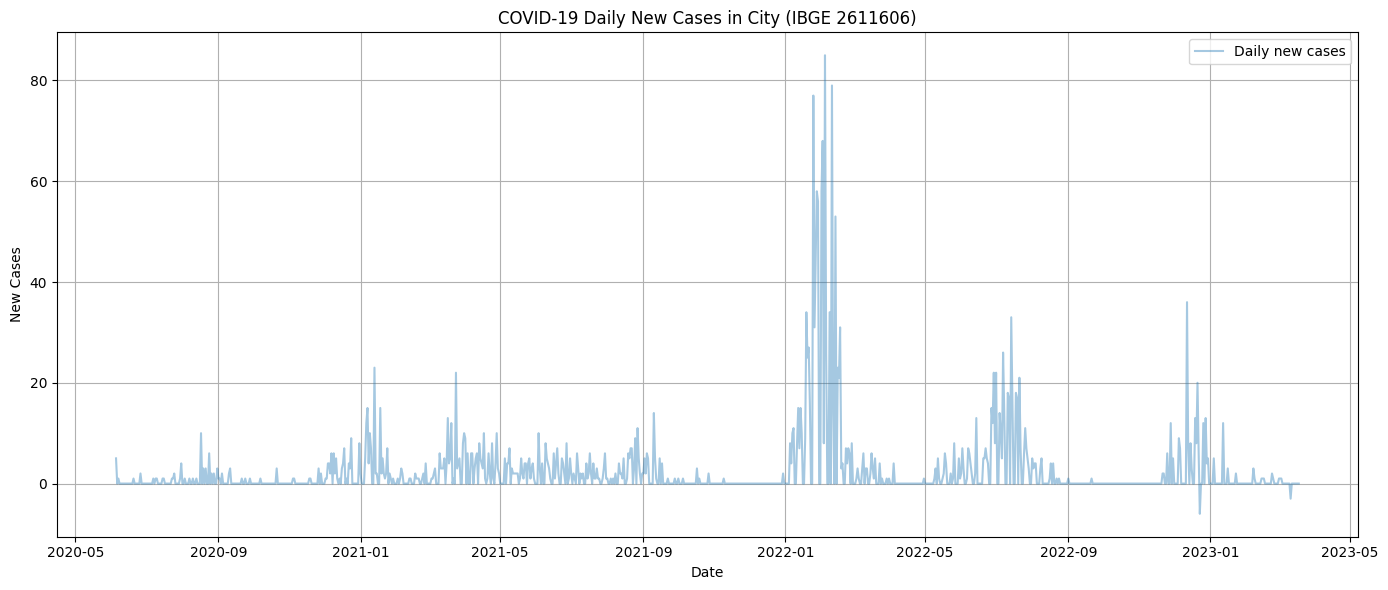

In [70]:
# Filter data for São Paulo
city = covid_df[covid_df['ibgeID'] == 3102308]

# Plotting new cases over time
plt.figure(figsize=(14, 6))
plt.plot(city['date'], city['newCases'], label='Daily new cases', alpha=0.4)
# plt.plot(city['date'], city['newCases'].rolling(window=7).mean(), label='7-day rolling avg', color='red')

# Labels and legend
plt.title("COVID-19 Daily New Cases in City (IBGE 2611606)")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
# Load data
covid_df = load_and_save_covid_data()
covid_df['newCases'] = covid_df['newCases'].fillna(0)

spike_cities = set()

window_size = 100
threshold = 10  # spike = mean + threshold * std

for city_id, group in covid_df.groupby('ibgeID'):
    group_sorted = group.sort_values('date')
    values = group_sorted['newCases'].values

    if len(values) < window_size:
        continue

    # Slide 30-day window
    for i in range(len(values) - window_size + 1):
        window = values[i:i + window_size]
        mean = window.mean()
        std = window.std()
        max_val = window.max()

        if std > 0 and max_val > mean + threshold * std:
            spike_cities.add(city_id)
            break  # stop at first detected spike

# Convert to DataFrame for inspection
spike_df = pd.DataFrame({'ibgeID': list(spike_cities)})
print(f"⚠️ Found {len(spike_df)} cities with 30-day window spikes.")
print(spike_df.head())

# Check a specific city
print("3300936 in spike_cities?", 3300936 in spike_cities)


[✓] Found saved COVID dataset at data/covid_brazil_combined.csv. Loading it...
⚠️ Found 0 cities with 30-day window spikes.
Empty DataFrame
Columns: [ibgeID]
Index: []
3300936 in spike_cities? False
